#Analyze Spotify Track Data
##In this notebook, I'll be exploring the data we scraped and cleaned in previous steps. I made some data changes based on early exploration of track features and ran the data through several ML models to try to find the most accurate way of predicting a track's popularity.

## Initialize data and see what we're working with

In [ ]:
# uploaded = files.upload()
# import os
# os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/content/spotify-f1cf5-firebase-adminsdk-xxrd4-763e07c601.json'
# import firebase_admin
# from firebase_admin import credentials
# from google.cloud import firestore

In [ ]:
# cred = credentials.Certificate('/content/spotify-f1cf5-firebase.json')
# firebase_admin.initialize_app(cred, {
#     'databaseURL': 'https://spotify-f1cf5.firebaseio.com'
# })

# db = firestore.Client()

# tracks_ref = db.collection(u'tracks')
# tracks = tracks_ref.stream()

# track_list = []
# for track in tracks:
#   track_list.append(track.to_dict())
# track_table = pd.DataFrame(track_list)

In [2]:
import pandas as pd
import numpy as np
from google.colab import files
uploaded = files.upload()

Saving cleaned_tracks_both.csv to cleaned_tracks_both.csv


In [3]:
track_table = pd.read_csv("cleaned_tracks_both.csv")

In [4]:
track_table.head()

,track_pop,track_name,track_id,track_year,track_spotify_genre,art_name,art_id,alb_name,alb_id,art_genre,duration_ms,time_signature,key,loudness,energy,speechiness,acousticness,mode,tempo,valence,danceability,instrumentalness,liveness,genre_words,master_popular_genre
0,50,"Turandot / Act 3: Turandot / Act 3: ""Nessun do...",1GqszY8D6qlMHY7KmA5wE8,2011,classical,Andrea Bocelli,3EA9hVIzKfFiQI0Kikz2wo,Concerto: One Night In Central Park (Remastered),7LkXjMXDhwqXl3l9zqxRRz,"['classical tenor', 'italian tenor', 'operatic...",247010,4,2,-9.841,0.41200,0.0357,0.94300,1,88.113,0.193,0.167,0.000121,0.7570,"{'classical': 1, 'tenor': 2, 'italian': 1, 'op...",pop
1,44,Bad Asteroid,5TzCDKy1ZmFZdW8100A8p9,2011,classical,The Aristocrats,1V4jsLjkic1Mxvdke86Qth,The Aristocrats,7GKzcJbW0Qernh0Xab1bIf,"['instrumental rock', 'jazz fusion', 'neo clas...",353667,4,11,-7.257,0.72700,0.0462,0.03010,0,87.349,0.391,0.485,0.758000,0.1630,"{'instrumental': 1, 'rock': 1, 'jazz': 2, 'fus...",rock
2,37,The Whispers,4VH3rKj1tmhUZtX3U43jBq,2011,classical,Harold Budd,3uOCouLFR4bVx0XeiQJSbl,In The Mist,3J8bwfrUYrzmuE0IqFLhUS,"['ambient', 'american contemporary classical',...",163000,3,9,-35.213,0.00385,0.0449,0.99500,0,141.201,0.117,0.228,0.917000,0.0858,"{'ambient': 2, 'american': 1, 'contemporary': ...",rock
3,41,"Time To Say Goodbye - Live At Central Park, Ne...",1Jw2mwSScPEROBomYw6L0g,2011,classical,Andrea Bocelli,3EA9hVIzKfFiQI0Kikz2wo,Concerto: One Night In Central Park (Remastered),7LkXjMXDhwqXl3l9zqxRRz,"['classical tenor', 'italian tenor', 'operatic...",253991,3,7,-9.827,0.30500,0.0318,0.93600,1,85.786,0.446,0.230,0.000002,0.7440,"{'classical': 1, 'tenor': 2, 'italian': 1, 'op...",pop
4,42,Anthem,0ZUPWnw89a0iLfNdcUiIm3,2011,classical,Iced Earth,3KEixcRfBS5K3E91Vn1Kdy,Dystopia,6la9AnaFIgSo4faEDcnHQx,"['hard rock', 'melodic metal', 'metal', 'neo c...",294613,4,3,-5.242,0.95400,0.0607,0.00894,0,163.995,0.287,0.454,0.000000,0.0659,"{'hard': 1, 'rock': 1, 'melodic': 1, 'metal': ...",rock


##Explore Numeric Variables
In this section, I'll be selecting just the numeric columns in our data and exploring their distributions, correlations, and more.

In [5]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
track_table_numerics = track_table.select_dtypes(include=[np.number])

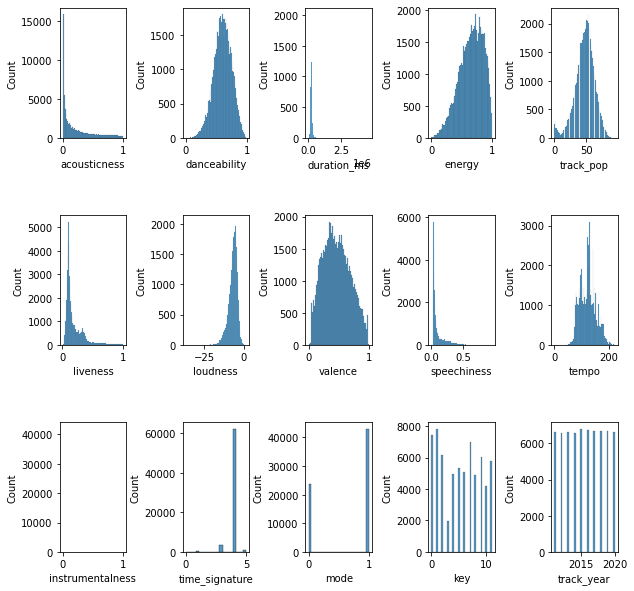

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
 
f, axes = plt.subplots(3, 5, figsize=(10, 10))
plt.subplots_adjust(wspace=.85, hspace=.6)
sns.histplot( track_table_numerics["acousticness"] , ax=axes[0, 0])
sns.histplot( track_table_numerics["danceability"] , ax=axes[0, 1])
sns.histplot( track_table_numerics["duration_ms"] , ax=axes[0, 2])
sns.histplot( track_table_numerics["energy"] , ax=axes[0, 3])
sns.histplot( track_table_numerics["track_pop"] , ax=axes[0, 4])
sns.histplot( track_table_numerics["liveness"] , ax=axes[1, 0])
sns.histplot( track_table_numerics["loudness"] , ax=axes[1, 1])
sns.histplot( track_table_numerics["valence"] , ax=axes[1, 2])
sns.histplot( track_table_numerics["speechiness"] , ax=axes[1, 3])
sns.histplot( track_table_numerics["tempo"] , ax=axes[1, 4])
sns.histplot( track_table_numerics["instrumentalness"] , ax=axes[2, 0])
sns.histplot( track_table_numerics["time_signature"] , ax=axes[2, 1])
sns.histplot( track_table_numerics["mode"] , ax=axes[2, 2])
sns.histplot( track_table_numerics["key"] , ax=axes[2, 3])
sns.histplot( track_table_numerics["track_year"] , ax=axes[2, 4])

I was pleased to see that our outcome variable, Track Popularity, had a mostly normal distribution. Since we were pulling tracks from Spotify based on simple queries, I was a bit concerned it would overselect songs with high popularity,  but this doesn't seem to be the case. The only non-normal feature of this histogram is the small spike at popularity 0.

Text(0.5, 1.0, 'Track Popularity')

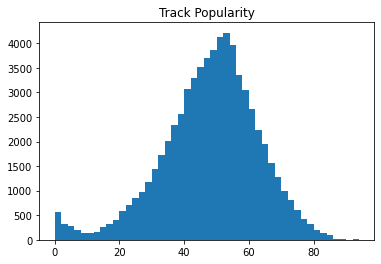

In [7]:
import matplotlib.pyplot as plt
plt.hist(track_table_numerics["track_pop"], bins=47)  #Chose 47 because it results in bins of size 2 (0-2,2-4, etc)
plt.title("Track Popularity")

Next, I wanted to see if there were any variables with extremely high correlations.

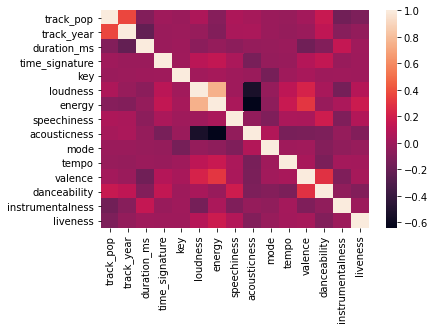

In [8]:
sns.heatmap(track_table_numerics.corr())

Based on this heatmap, I determined that loudness and energy were clearly highly correlative, so I chose to drop energy, as this also had a high negative correlation with acousticness.

In [10]:
print("Energy/Loudness correlation:", np.corrcoef(track_table_numerics.energy, track_table_numerics.loudness))
print("Energy/Accousticness correlation:", np.corrcoef(track_table_numerics.energy, track_table_numerics.acousticness))

Energy/Loudness correlation: [[1.         0.75027295]
 [0.75027295 1.        ]]
Energy/Accousticness correlation: [[ 1.         -0.64270152]
 [-0.64270152  1.        ]]


I then converted my categorical variables mode, key, time_signature, and both genres to dummies. I dropped columns like the artist name, album name, original genre list, and more. I did this because each of these had so many possible values in the dataset that it was completely impractical to create dummies for each of these values. I also felt that it would be a bit unfair to include things like artist name, as this would likely be hugely predictive in determining the track's popularity and would defeat the purpose of analysing the audible qualities.

In [8]:
track_table_dummies = pd.get_dummies(track_table,columns=['mode','key','time_signature','track_spotify_genre','master_popular_genre'],drop_first=True)
#track_table_dummies = pd.get_dummies(track_table,columns=['mode','time_signature','track_spotify_genre','master_popular_genre'],drop_first=True)

track_table_dummies.drop(['energy'], axis=1, inplace=True)
track_table_dummies = track_table_dummies.select_dtypes(include=[np.number])
track_table_dummies.dropna(inplace=True)


At this point, I was confident in my dataset and wanted to start trying to predict the target variable track_pop.

In [15]:
track_table.head()

,track_pop,track_name,track_id,track_year,track_spotify_genre,art_name,art_id,alb_name,alb_id,art_genre,duration_ms,time_signature,key,loudness,energy,speechiness,acousticness,mode,tempo,valence,danceability,instrumentalness,liveness,genre_words,master_popular_genre
0,50,"Turandot / Act 3: Turandot / Act 3: ""Nessun do...",1GqszY8D6qlMHY7KmA5wE8,2011,classical,Andrea Bocelli,3EA9hVIzKfFiQI0Kikz2wo,Concerto: One Night In Central Park (Remastered),7LkXjMXDhwqXl3l9zqxRRz,"['classical tenor', 'italian tenor', 'operatic...",247010,4,2,-9.841,0.41200,0.0357,0.94300,1,88.113,0.193,0.167,0.000121,0.7570,"{'classical': 1, 'tenor': 2, 'italian': 1, 'op...",pop
1,44,Bad Asteroid,5TzCDKy1ZmFZdW8100A8p9,2011,classical,The Aristocrats,1V4jsLjkic1Mxvdke86Qth,The Aristocrats,7GKzcJbW0Qernh0Xab1bIf,"['instrumental rock', 'jazz fusion', 'neo clas...",353667,4,11,-7.257,0.72700,0.0462,0.03010,0,87.349,0.391,0.485,0.758000,0.1630,"{'instrumental': 1, 'rock': 1, 'jazz': 2, 'fus...",rock
2,37,The Whispers,4VH3rKj1tmhUZtX3U43jBq,2011,classical,Harold Budd,3uOCouLFR4bVx0XeiQJSbl,In The Mist,3J8bwfrUYrzmuE0IqFLhUS,"['ambient', 'american contemporary classical',...",163000,3,9,-35.213,0.00385,0.0449,0.99500,0,141.201,0.117,0.228,0.917000,0.0858,"{'ambient': 2, 'american': 1, 'contemporary': ...",rock
3,41,"Time To Say Goodbye - Live At Central Park, Ne...",1Jw2mwSScPEROBomYw6L0g,2011,classical,Andrea Bocelli,3EA9hVIzKfFiQI0Kikz2wo,Concerto: One Night In Central Park (Remastered),7LkXjMXDhwqXl3l9zqxRRz,"['classical tenor', 'italian tenor', 'operatic...",253991,3,7,-9.827,0.30500,0.0318,0.93600,1,85.786,0.446,0.230,0.000002,0.7440,"{'classical': 1, 'tenor': 2, 'italian': 1, 'op...",pop
4,42,Anthem,0ZUPWnw89a0iLfNdcUiIm3,2011,classical,Iced Earth,3KEixcRfBS5K3E91Vn1Kdy,Dystopia,6la9AnaFIgSo4faEDcnHQx,"['hard rock', 'melodic metal', 'metal', 'neo c...",294613,4,3,-5.242,0.95400,0.0607,0.00894,0,163.995,0.287,0.454,0.000000,0.0659,"{'hard': 1, 'rock': 1, 'melodic': 1, 'metal': ...",rock


##Creating and Tuning Models

In [40]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

I started by splitting the dataset into a training set (67%) and a test set (33%).

In [10]:
X = track_table_dummies.iloc[:,1:]
y = track_table_dummies.iloc[:,0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## Linear Models
### Simple linear regression
I started by performing a simple multivariate linear regression, as this basic model would serve as a baseline for what to expect for our more complex models.

In [11]:
model = sm.OLS(y_train,X_train)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              track_pop   R-squared (uncentered):                   0.928
Model:                            OLS   Adj. R-squared (uncentered):              0.928
Method:                 Least Squares   F-statistic:                          1.475e+04
Date:                Mon, 14 Jun 2021   Prob (F-statistic):                        0.00
Time:                        02:05:41   Log-Likelihood:                     -1.7929e+05
No. Observations:               44678   AIC:                                  3.587e+05
Df Residuals:                   44639   BIC:                                  3.590e+05
Df Model:                          39                                                  
Covariance Type:            nonrobust                                                  
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
track_year                      0.0489      0.003     14.806      0.000       0.042       0.055
duration_ms                 -7.258e-06   9.28e-07     -7.823      0.000   -9.08e-06   -5.44e-06
loudness                        0.4966      0.028     17.862      0.000       0.442       0.551
speechiness                     1.7271      0.746      2.314      0.021       0.264       3.190
acousticness                    5.1878      0.302     17.197      0.000       4.597       5.779
tempo                           0.0008      0.002      0.361      0.718      -0.004       0.005
valence                        -3.5675      0.322    -11.090      0.000      -4.198      -2.937
danceability                   17.5364      0.539     32.555      0.000      16.481      18.592
instrumentalness               -9.8620      0.346    -28.528      0.000     -10.540      -9.184
liveness                      -10.4296      0.412    -25.326      0.000     -11.237      -9.622
mode_1                         -0.3075      0.142     -2.163      0.031      -0.586      -0.029
key_1                          -0.0540      0.267     -0.203      0.839      -0.577       0.469
key_2                          -0.4519      0.281     -1.606      0.108      -1.003       0.100
key_3                           0.7739      0.410      1.887      0.059      -0.030       1.578
key_4                          -0.3939      0.304     -1.296      0.195      -0.990       0.202
key_5                           0.8387      0.296      2.833      0.005       0.259       1.419
key_6                           0.0367      0.300      0.123      0.902      -0.551       0.624
key_7                          -0.3977      0.273     -1.456      0.145      -0.933       0.138
key_8                           0.4151      0.301      1.378      0.168      -0.175       1.006
key_9                          -1.0577      0.283     -3.733      0.000      -1.613      -0.502
key_10                          0.2087      0.319      0.655      0.512      -0.416       0.833
key_11                         -0.2323      0.293     -0.794      0.427      -0.806       0.341
time_signature_1              -61.3608      6.713     -9.141      0.000     -74.518     -48.204
time_signature_3              -61.1911      6.649     -9.203      0.000     -74.223     -48.159
time_signature_4              -61.8123      6.645     -9.303      0.000     -74.836     -48.789
time_signature_5              -61.3730      6.667     -9.205      0.000     -74.441     -48.305
track_spotify_genre_country     2.5872      0.734      3.526      0.000       1.149       4.025
track_spotify_genre_hip-hop     8.4786      0.735     11.543      0.000       7.039       9.918
track_sp

In [19]:
print("Linear Regression:")
print("Test mean absolute error:", mean_absolute_error(y_test, results.predict(X_test)))
lr_mse = mean_squared_error(y_test,results.predict(X_test))
print("Test mean-squared error:", lr_mse)
print("Test root mean squared error:", np.sqrt(lr_mse))


Linear Regression:
Test mean absolute error: 10.028024895480225
Test mean-squared error: 178.38298913754434
Test root mean squared error: 13.35600947654442


The linear regression provided a few interesting insights. 

Firstly, our baseline MAE will be about 10, meaning that the popularity predictions of a simple linear regression are off by about 10 popularity per prediction (scale is 1-100).

Secondly, our linear regression model has quite a high R-squared at .928, suggesting that almost 93% of the variation in popularity can be determined by the variables in the model. This is promising and a lot higher than I expected.

The regression also showed that a large number of our variables are significant, with most of the p-values falling below .05. One set of features, though, that did not seem very useful was *tempo* with a p-value of 0.718 and a coefficient of 0.0008. 

I chose to drop this from the dataset, re-partition the training and test set, and see how it affected the Linear Regression model. I'm hoping for and expecting little drop in the R-Squared.

In [12]:
track_table_dummies.drop(['tempo'], axis=1, inplace=True)
X = track_table_dummies.iloc[:,1:]
y = track_table_dummies.iloc[:,0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [13]:
model = sm.OLS(y_train,X_train)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              track_pop   R-squared (uncentered):                   0.928
Model:                            OLS   Adj. R-squared (uncentered):              0.928
Method:                 Least Squares   F-statistic:                          1.514e+04
Date:                Mon, 14 Jun 2021   Prob (F-statistic):                        0.00
Time:                        02:07:41   Log-Likelihood:                     -1.7929e+05
No. Observations:               44678   AIC:                                  3.586e+05
Df Residuals:                   44640   BIC:                                  3.590e+05
Df Model:                          38                                                  
Covariance Type:            nonrobust                                                  
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
track_year                      0.0489      0.003     14.807      0.000       0.042       0.055
duration_ms                 -7.264e-06   9.28e-07     -7.831      0.000   -9.08e-06   -5.45e-06
loudness                        0.4970      0.028     17.890      0.000       0.443       0.551
speechiness                     1.7504      0.744      2.354      0.019       0.293       3.208
acousticness                    5.1783      0.301     17.232      0.000       4.589       5.767
valence                        -3.5605      0.321    -11.089      0.000      -4.190      -2.931
danceability                   17.5053      0.532     32.922      0.000      16.463      18.548
instrumentalness               -9.8580      0.346    -28.532      0.000     -10.535      -9.181
liveness                      -10.4336      0.412    -25.345      0.000     -11.240      -9.627
mode_1                         -0.3071      0.142     -2.160      0.031      -0.586      -0.028
key_1                          -0.0540      0.267     -0.203      0.840      -0.577       0.469
key_2                          -0.4518      0.281     -1.606      0.108      -1.003       0.100
key_3                           0.7733      0.410      1.885      0.059      -0.031       1.577
key_4                          -0.3936      0.304     -1.295      0.195      -0.989       0.202
key_5                           0.8388      0.296      2.834      0.005       0.259       1.419
key_6                           0.0359      0.300      0.120      0.905      -0.551       0.623
key_7                          -0.3982      0.273     -1.458      0.145      -0.933       0.137
key_8                           0.4159      0.301      1.381      0.167      -0.175       1.006
key_9                          -1.0579      0.283     -3.733      0.000      -1.613      -0.502
key_10                          0.2091      0.319      0.656      0.512      -0.415       0.833
key_11                         -0.2321      0.293     -0.793      0.427      -0.805       0.341
time_signature_1              -61.2638      6.707     -9.134      0.000     -74.410     -48.118
time_signature_3              -61.0743      6.641     -9.197      0.000     -74.091     -48.058
time_signature_4              -61.7025      6.638     -9.296      0.000     -74.712     -48.693
time_signature_5              -61.2699      6.661     -9.198      0.000     -74.326     -48.214
track_spotify_genre_country     2.5938      0.733      3.537      0.000       1.156       4.031
track_spotify_genre_hip-hop     8.4841      0.734     11.553      0.000       7.045       9.923
track_spotify_genre_house       8.9258      0.726     12.290      0.000       7.502      10.349
track_sp

As expected, no change in the R-squared. The only other variables I considered dropping were key and master_popular_genre because several of the categories for these features are insignificant. However, since I would also have to drop the significant categories if I wanted to drop the insignificant ones, I chose to leave them in.

In [14]:
print("Linear Regression:")
print("Test mean absolute error:", mean_absolute_error(y_test, results.predict(X_test)))
lr_mse = mean_squared_error(y_test,results.predict(X_test))
print("Test mean-squared error:", lr_mse)
print("Test root mean squared error:", np.sqrt(lr_mse))

Linear Regression:
Test mean absolute error: 10.029911884302587
Test mean-squared error: 178.2921427513868
Test root mean squared error: 13.35260808798741


### Regularized Linear Models
I also tried a Ridge regression and a Lasso regression to check out how regularization would improve the linear model. For both of these regressions, I varied the regularization strength to see what alpha performed the best:

In [34]:
alphas = np.array([1, 0.5, .01, 0.05, .001, 0.005, 0.001, 0.0005])
ridge_grid = GridSearchCV(estimator=linear_model.Ridge(), param_grid=dict(alpha=alphas), cv=3)
ridge_grid.fit(X_train,y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': array([1.e+00, 5.e-01, 1.e-02, 5.e-02, 1.e-03, 5.e-03, 1.e-03, 5.e-04])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [36]:
print("Ridge Regression:")
print("The best score is {}".format(ridge_grid.best_score_))
print("The best hyper parameter setting is {}".format(ridge_grid.best_params_))
print("Test mean absolute error:", mean_absolute_error(y_test, ridge_grid.predict(X_test)))
ridge_mse = mean_squared_error(y_test,grid.predict(X_test))
print("Test mean-squared error:", ridge_mse)
print("Test root mean squared error:", np.sqrt(ridge_mse))

Ridge Regression:
The best score is 0.29565428158944934
The best hyper parameter setting is {'alpha': 1.0}
Test mean absolute error: 8.96323766730061
Test mean-squared error: 156.8194017031554
Test root mean squared error: 12.522755355877372


In [31]:
from sklearn import linear_model
alphas = np.array([1, 0.5, .01, 0.05, .001, 0.005, 0.001, 0.0005])
lasso_grid = GridSearchCV(estimator=linear_model.Lasso(), param_grid=dict(alpha=alphas), cv=3)
lasso_grid.fit(X_train,y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': array([5.e-01, 5.e-02, 5.e-03, 5.e-04, 1.e+00, 1.e-01, 1.e-02, 1.e-03])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [37]:
print("Lasso Regression:")
print("The best score is {}".format(lasso_grid.best_score_))
print("The best hyper parameter setting is {}".format(lasso_grid.best_params_))
print("Test mean absolute error:", mean_absolute_error(y_test, lasso_grid.predict(X_test)))
lasso_mse = mean_squared_error(y_test,lasso_grid.predict(X_test))
print("Test mean-squared error:", lasso_mse)
print("Test root mean squared error:", np.sqrt(lasso_mse))

Lasso Regression:
The best score is 0.2957197876221089
The best hyper parameter setting is {'alpha': 0.001}
Test mean absolute error: 8.964674773868138
Test mean-squared error: 156.8194017031554
Test root mean squared error: 12.522755355877372


These models performed a bit better, suggesting that the original linear model was overfitting a bit. We'll see if we can improve over this 9 MSE using more complex ML Models below.

##Machine Learning Models
For each of these models, I used GridSearchCV to try a number of hyperparameters that could potentially improve performance of each of the models.

I tried a Random Forest, Gradient Boost, Ada Boost, and Neural Network. At the end, I summarized all of the models' performances.

In [49]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor

In [65]:
def print_score(modelName, grid):
  print(modelName)
  print("The best score is {}".format(grid.best_score_))
  print("The best hyper parameter setting is {}".format(grid.best_params_))
  mae = mean_absolute_error(y_test, grid.predict(X_test))
  print("Test mean absolute error:", mae)
  mse = mean_squared_error(y_test,grid.predict(X_test))
  print("Test mean-squared error:", mse)
  print("Test root mean squared error:", np.sqrt(mse))
  return mae

####Decision Tree

In [ ]:
dt_param_grid = {
              'max_depth':range(1,16),
              #'max_depth': 9,
              'min_samples_split':range(2,10)#,
              #'min_samples_split': 8
}
dt_grid = GridSearchCV(DecisionTreeRegressor(), dt_param_grid, cv=3, verbose=2).fit(X_train, y_train)
# summarize the results of the grid search

In [68]:
dt_mae = print_score('Decision Tree', dt_grid)

Decision Tree
The best score is 0.4157645937102004
The best hyper parameter setting is {'max_depth': 10, 'min_samples_split': 9}
Test mean absolute error: 8.05595945693038
Test mean-squared error: 129.47829591883126
Test root mean squared error: 11.378853014202761


###Random Forest

In [ ]:
rf_param_grid = {'bootstrap': [True, False],
              'n_estimators':range(50,400, 50),
              'max_depth':range(3,12, 2),
              'min_samples_split': [2,3,4]
}
rf_grid = GridSearchCV(RandomForestRegressor(), rf_param_grid, cv=3, verbose=2).fit(X_train, y_train)
# summarize the results of the grid search

In [ ]:
rf_mae = print_score('Random Forest', rf_grid)

Random Forest:
Test mean absolute error: 9.994666435671931
Test mean-squared error: 184.8183583245701
Test root mean squared error: 13.594791588125583


### Gradient Boost

In [57]:
gb_param_grid = {
     #'learning_rate': [.01,.1,1],
     'learning_rate':[.01,.1],
     #'max_depth': [4,5,6,7],
     'max_depth':[7],
     #'n_estimators': range(50,150,20),
     'n_estimators':[130],
     #'min_samples_split': [0.01, 0.05, 0.1]
     'min_samples_split':[.01] 
}

gb_grid = GridSearchCV(GradientBoostingRegressor(), gb_param_grid, cv=3, verbose=2).fit(X_train, y_train)

Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV] learning_rate=0.01, max_depth=7, min_samples_split=0.01, n_estimators=130 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  learning_rate=0.01, max_depth=7, min_samples_split=0.01, n_estimators=130, total=  24.9s
[CV] learning_rate=0.01, max_depth=7, min_samples_split=0.01, n_estimators=130 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   24.9s remaining:    0.0s


[CV]  learning_rate=0.01, max_depth=7, min_samples_split=0.01, n_estimators=130, total=  24.8s
[CV] learning_rate=0.01, max_depth=7, min_samples_split=0.01, n_estimators=130 
[CV]  learning_rate=0.01, max_depth=7, min_samples_split=0.01, n_estimators=130, total=  24.7s
[CV] learning_rate=0.1, max_depth=7, min_samples_split=0.01, n_estimators=130 
[CV]  learning_rate=0.1, max_depth=7, min_samples_split=0.01, n_estimators=130, total=  24.2s
[CV] learning_rate=0.1, max_depth=7, min_samples_split=0.01, n_estimators=130 
[CV]  learning_rate=0.1, max_depth=7, min_samples_split=0.01, n_estimators=130, total=  24.5s
[CV] learning_rate=0.1, max_depth=7, min_samples_split=0.01, n_estimators=130 
[CV]  learning_rate=0.1, max_depth=7, min_samples_split=0.01, n_estimators=130, total=  24.3s


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  2.5min finished


In [21]:
gb_mae = print_score('Gradient Boost', gb_grid)

Gradient Boost:
Test mean absolute error: 7.57183050106379
Test mean-squared error: 104.85587891173364
Test root mean squared error: 10.239915962142152


### ADA Boost

In [ ]:
ab_param_grid = {
  'n_estimators': range(50,150,20),
  'learning_rate' : [0.01,0.05,0.1,0.3,1],
  'loss' : ['linear', 'square', 'exponential']
}

ab_grid = GridSearchCV(AdaBoostRegressor(), ab_param_grid, cv=3, verbose=2).fit(X_train, y_train)

In [ ]:
ab_mae = print_score('Ada Boost', ab_grid)

Ada Boost:
Test mean absolute error: 9.64163074153601
Test mean-squared error: 163.10401003588888
Test root mean squared error: 12.771218032587528


### XG Boost

In [ ]:
xg_param_grid = {
    #'clf__n_estimators': [50, 100, 150, 200],
    'clf__n_estimators': 50,
    #'clf__learning_rate': [0.01, 0.1, 0.2, 0.3],
    'clf__learning_rate': 0.01,
    #'clf__max_depth': range(3,10),
    'clf__max_depth': 3,
    'fs__score_func': ["chi2"],
    'fs__k': [10],
    'objective':['reg:squarederror']
}

xg_grid = GridSearchCV(XGBRegressor(), xg_param_grid, cv=3, verbose=2).fit(X_train, y_train)

In [48]:
xg_mae = print_score('XG Boost', xg_grid)

XG Boost:
Test mean absolute error: 7.997105604435632
Test mean-squared error: 121.06921959651262
Test root mean squared error: 11.003145895447929


### Neural Network

In [ ]:
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
nn_param_grid = {
     #'activation': ['logistic', 'relu'],
     'activation': ['logistic'],
     #'learning_rate': ['constant','adaptive'],
     'learning_rate': 'adaptive',
     #'learning_rate_init': [.001,.01],
     'learning_rate_init': 0.01,
     #'hidden_layer_sizes': [3,5,10,50,100],
     'hidden_layer_sizes': 10,
     'max_iter': [400]

}

nn_grid = GridSearchCV(MLPRegressor(), nn_param_grid, cv=3).fit(X_train, y_train)

The best score is -8.038546307857312e-07
The best hyper parameter setting is {'activation': 'logistic', 'hidden_layer_sizes': 10, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'max_iter': 400}


In [ ]:
nn_mae = print_score('Neural Network', nn_grid)

Neural Network:
Test mean absolute error: 13.12576867922241
Test mean-squared error: 271.698105917296
Test root mean squared error: 16.483267452701725


##Model Comparisons


## Visualizing Error

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>


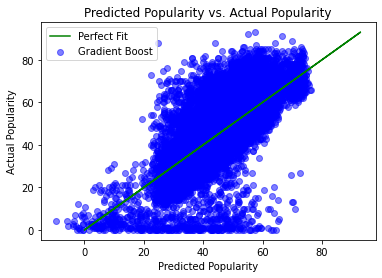

<Figure size 864x576 with 0 Axes>

In [ ]:
gb_pred = gb_grid.predict(X_test)
plt.scatter(x=gb_pred, y=y_test, alpha=.5, color = 'b', label = "Gradient Boost")
#plt.scatter(x=ada_pred, y=test_y, alpha=.5, color = 'r', label = "Ada Boost")
plt.plot(y_test, y_test, color = 'g', label = 'Perfect Fit')
plt.xlabel('Predicted Popularity')
plt.ylabel('Actual Popularity')
plt.legend(loc='upper left')
plt.title("Predicted Popularity vs. Actual Popularity")
plt.figure(figsize=(12,8))
print(plt)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>


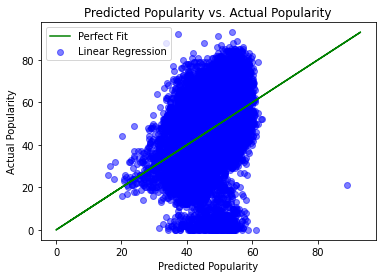

<Figure size 1728x1152 with 0 Axes>

In [ ]:
reg_pred = results.predict(X_test)
plt.scatter(x=reg_pred, y=y_test, alpha=.5, color = 'b', label = "Linear Regression")
#plt.scatter(x=ada_pred, y=test_y, alpha=.5, color = 'r', label = "Ada Boost")
plt.plot(y_test, y_test, color = 'g', label = 'Perfect Fit')
plt.xlabel('Predicted Popularity')
plt.ylabel('Actual Popularity')
plt.legend(loc='upper left')
plt.title("Predicted Popularity vs. Actual Popularity")
plt.figure(figsize=(24,16))
print(plt)

Add error analysis per genre (violin)

histogram of error

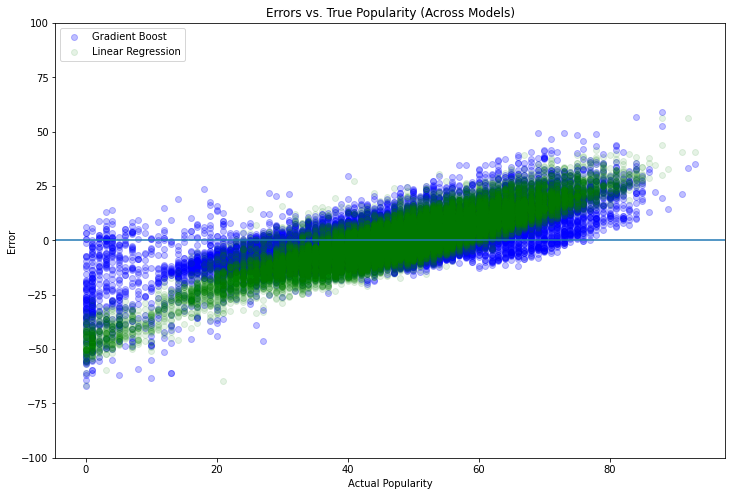

In [ ]:
plt.figure(figsize=(12,8))
plt.scatter(y_test,y_test - gb_grid.predict(X_test),color='b', alpha = .25, label = 'Gradient Boost')
plt.scatter(y_test,y_test - results.predict(X_test),color='g', alpha = .1, label = 'Linear Regression')
#plt.scatter(test_outcome,test_outcome - knn_grid.predict(test_features),color='g', alpha = .5, label = 'Random Forests')
plt.axhline(y = 0)
plt.ylim(-100, 100)
plt.xlabel('Actual Popularity')
plt.ylabel('Error')
plt.title("Errors vs. True Popularity (Across Models)")
plt.legend(loc='upper left')
plt.show()

In [ ]:
tracks_clean = pd.read_csv('cleaned_tracks_both.csv')
genres = pd.DataFrame(tracks_clean["track_spotify_genre"])

# get errors for the neural network
gb_errors =  pd.DataFrame(y_test - gb_grid.predict(X_test))
gb_errors.rename({"track_pop": "error"}, axis='columns', inplace=True)

# overwrite indexes because this is horrible
gb_errors.index = gb_errors.index.astype(str)
genres.index = genres.index.astype(str)

res = gb_errors.join(genres)


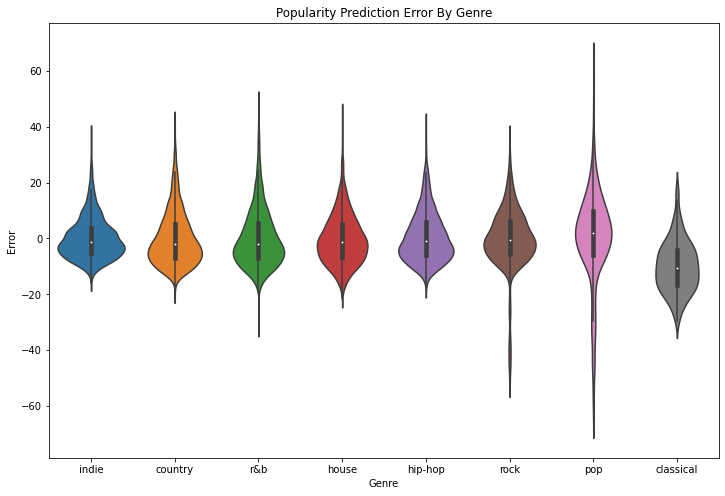

In [ ]:
plt.figure(figsize=(12,8))
violin_plot = sns.violinplot(x="track_spotify_genre", y="error", data=res)

plt.xlabel('Genre')
plt.ylabel('Error') 
plt.title('Popularity Prediction Error By Genre')

plt.show(violin_plot)

Text(0.5, 1.0, 'Error Histogram')

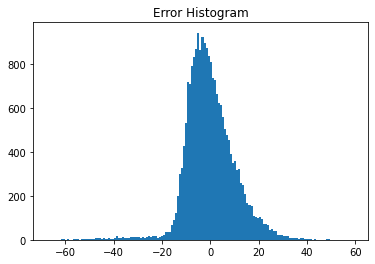

In [ ]:
plt.hist(y_test - gb_grid.predict(X_test), bins='auto')  # arguments are passed to np.histogram
plt.title("Error Histogram")